# DAIA and Machine Learning Notebook

AI-driven predictive modeling to estimate the probability that the blue team wins a ranked match (0–1). This notebook follows a DAIA-style flow (Data Understanding -> Analysis -> Interpretation) and evaluates four candidate models, using only the training split for EDA to avoid leakage.

# Overview and setup

- Goal: Predict match outcome probability for League of Legends ranked games from early-game state (around 15 minutes) and pregame info.
- Data: Cleaned 15-minute dataset prepared in `data/cleaned/` (pregame kept separate).
- Target: `blue_win` (1=blue wins, 0=blue loses).
- Main model: Random Forest (Classifier) - strong non-linear baseline with `predict_proba`.
- Also tested:
  1. Logistic Regression (linear baseline)
  2. K-Nearest Neighbors (distance-weighted)
  3. Linear Regression (as a simple probability regressor)
  - Note: XGBoost could be a future upgrade; for now Random Forest is our primary model.
- Evaluation focus:
  - Thresholded metrics at 0.5: Accuracy, Precision, Recall, F1
  - Probability-quality metrics: ROC-AUC, PR-AUC (Average Precision), Brier score, Log Loss
  - Calibration: reliability diagram to check if predicted % matches observed win rates

### Hypotheses (before training)

- I expect a non-linear model (Random Forest) to outperform linear baselines due to interactions between gold, objectives, and lane stats.
- I expect Logistic Regression to be a strong, interpretable baseline that may underfit non-linearities.
- I expect KNN to lag on high-dimensional numeric features even with scaling.
- I expect Linear Regression (thresholded) to be close to Logistic but slightly worse.

In [2]:
# Imports and setup
import os, json, warnings
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font_scale=1)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import CalibrationDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load cleaned dataset
cleaned_dir = os.path.join('data', 'cleaned')
fifteen_clean_path = os.path.join(cleaned_dir, 'lol_15min_data_clean.parquet')
fifteen_clean_csv = os.path.join(cleaned_dir, 'lol_15min_data_clean.csv')
train_path = os.path.join(cleaned_dir, 'lol_15min_train.parquet')
val_path = os.path.join(cleaned_dir, 'lol_15min_val.parquet')
test_path = os.path.join(cleaned_dir, 'lol_15min_test.parquet')

def read_any(path_parquet: str, path_csv: str) -> pd.DataFrame:
    if os.path.exists(path_parquet):
        try:
            return pd.read_parquet(path_parquet)
        except Exception as exc:
            warnings.warn(f'Failed to read {path_parquet} ({exc}); will try CSV.')
    if os.path.exists(path_csv):
        try:
            return pd.read_csv(path_csv)
        except Exception as exc:
            raise RuntimeError(f'Could not read {path_csv}: {exc}') from exc
    raise FileNotFoundError(f'No dataset available at {path_parquet} or {path_csv}')

# Prefer precomputed splits if present, otherwise load full clean dataset and split
if os.path.exists(train_path) and os.path.exists(test_path):
    try:
        train_df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path) if os.path.exists(val_path) else None
        test_df = pd.read_parquet(test_path)
        print('Loaded precomputed splits from data/cleaned.')
    except Exception as exc:
        warnings.warn(f'Split parquet read failed ({exc}); reverting to full dataset split.')
        full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
        stratify_col = full_df['blue_win'] if 'blue_win' in full_df.columns else None
        train_df, test_df = train_test_split(
            full_df, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_col
        )
        val_df = None
else:
    full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
    stratify_col = full_df['blue_win'] if 'blue_win' in full_df.columns else None
    train_df, test_df = train_test_split(
        full_df, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_col
    )
    val_df = None

for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    shape = 'None' if df is None else df.shape
    print(f'{name}: {shape}')

Loaded precomputed splits from data/cleaned.
train: (698, 20)
val: (150, 20)
test: (150, 20)


In [4]:
# Feature/label selection and minimal cleaning
LABEL_COL = 'blue_win'
ID_LIKE = {'matchId', 'gameId', 'match_id'}

def prepare_xy(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    assert LABEL_COL in df.columns, f'Missing label column: {LABEL_COL}'
    y = df[LABEL_COL].astype(int).clip(0, 1)
    # pick numeric features excluding label and ids
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != LABEL_COL]
    # include objective/categorical encodings if present and numeric
    drop_cols = [c for c in df.columns if c in ID_LIKE]
    X = df.drop(columns=drop_cols, errors='ignore')[num_cols].copy()
    # fill remaining NaNs in numeric features
    X = X.fillna(0)
    return X, y

X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_val, y_val = (prepare_xy(val_df) if val_df is not None else (None, None))

X_train.shape, X_test.shape

((698, 14), (150, 14))

## Correlation heatmap 

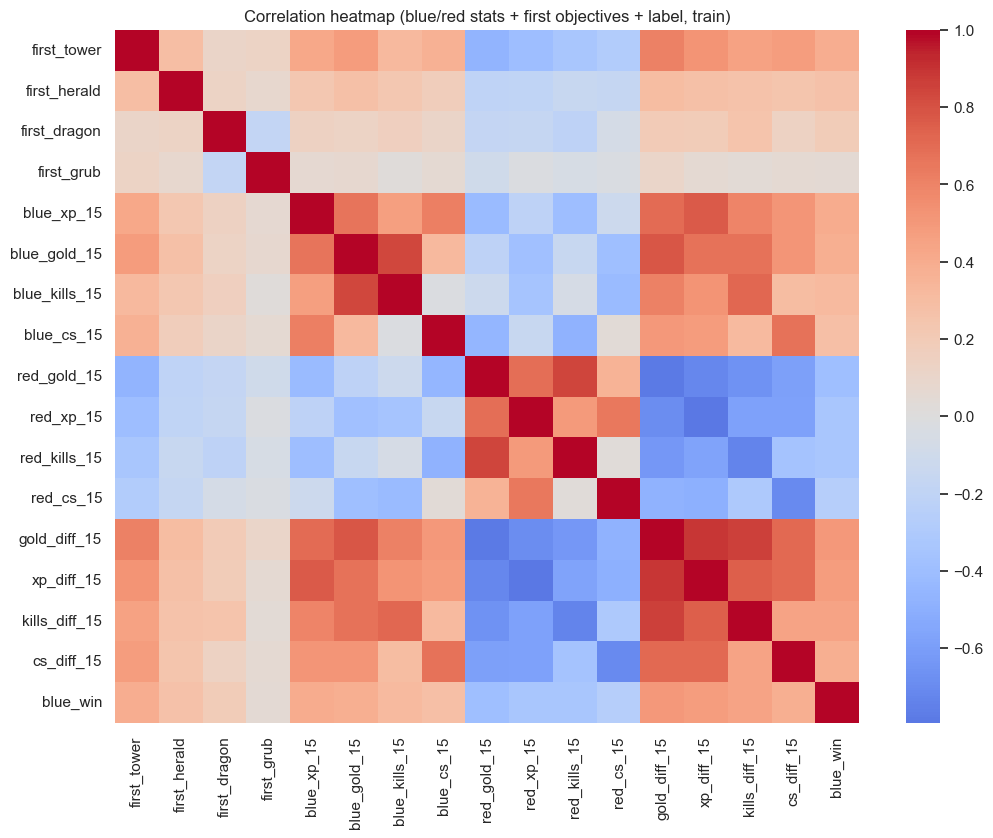

In [10]:
# Correlation heatmap for high-impact features (train)
tmp = train_df.copy()

# Normalize objective names and add common aliases
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]

# Cast boolean flags to integers so they appear in correlations
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns to binary if they store team strings
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if col in tmp.columns and tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

# Compute correlations including numeric + converted boolean/objective flags
num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_raw = tmp[num_cols].corrwith(tmp['blue_win'])
corr_series = corr_raw.fillna(0).sort_values(key=np.abs, ascending=False)

# Ensure all first-objective flags are included, even if correlation is 0/NaN
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr_series.get(c, 0)), reverse=True)

# Build an ordered list prioritizing objectives, then blue_, red_, and remaining stats
ordered = []
for c in first_objectives:
    if c in tmp.columns and c not in ordered:
        ordered.append(c)

group_order = [
    [c for c in corr_series.index if c.startswith('blue_')],
    [c for c in corr_series.index if c.startswith('red_')],
    [c for c in corr_series.index if not (c.startswith('blue_') or c.startswith('red_'))]
 ]
for group in group_order:
    for c in group:
        if c not in ordered:
            ordered.append(c)

# Limit to a manageable number of features while keeping diversity
top_feats = ordered[:20] if ordered else []
if top_feats:
    hm_cols = top_feats + ['blue_win']
    hm = tmp[hm_cols].copy().replace([np.inf, -np.inf], np.nan).dropna()
    plt.figure(figsize=(12, 9))
    sns.heatmap(hm.corr(), annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation heatmap (blue/red stats + first objectives + label, train)')
    plt.show()
else:
    print('Skipping heatmap: no correlations computed.')


This correlation heatmap now includes high-impact features from both blue and red teams alongside all `first_` objective flags and the label (`blue_win`), while skipping `gameDuration` since it brings little early-state insight.

From this heatmap I see:
- Early resource gaps (`gold_diff_15`, `xp_diff_15`, `cs_diff_15`, `kills_diff_15`) still cluster and positively correlate with `blue_win`, confirming that blue-side leads matter.
- Blue absolute stats tend to be warm (positive) while the corresponding red stats are cool (negative), making it easy to spot mirrored relationships.
- Objective flags such as `first_tower`, `first_dragon`, `first_herald`, `first_grub`, and others remain visible even if their correlation rank is mid-pack, keeping early objective control in view.

Conclusion: When I compare blue vs red entries, I check whether the differential alone is sufficient or whether the absolute team values provide extra nuance for the models.

## KDEs (class-wise distributions)

C:\Users\alexs\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\alexs\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


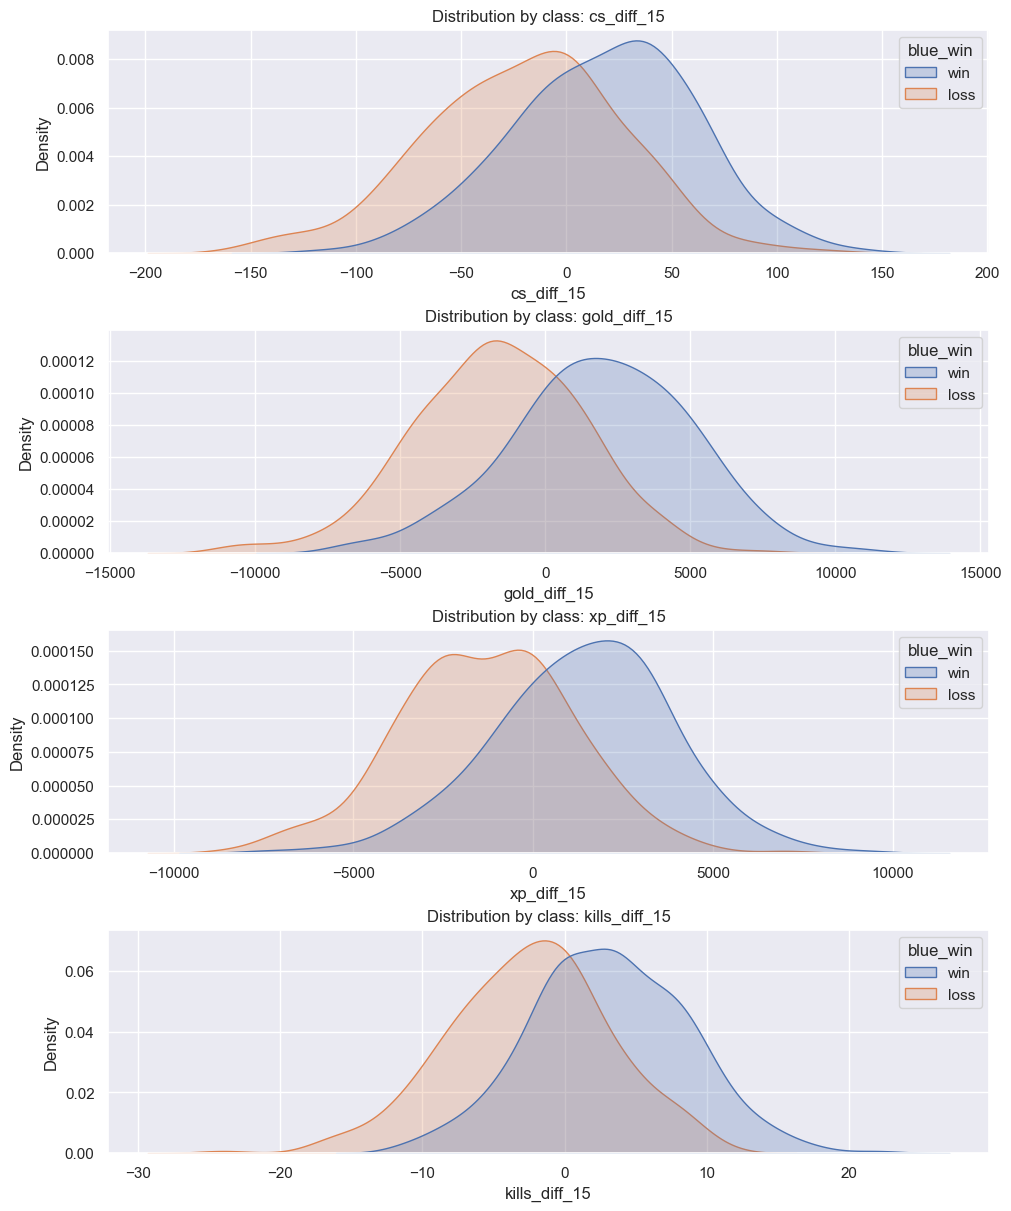

In [ ]:
# Visualize distributions for top features by class (skip binary flags)
if 'corr' not in globals() or corr is None or len(corr) == 0:
    tmp = train_df.copy()
    if 'first_turret' in tmp.columns and 'first_tower' not in tmp.columns:
        tmp['first_tower'] = tmp['first_turret']
    if 'first_drake' in tmp.columns and 'first_dragon' not in tmp.columns:
        tmp['first_dragon'] = tmp['first_drake']
    bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        tmp[bool_cols] = tmp[bool_cols].astype(int)
    obj_cols = [c for c in tmp.columns if c.startswith('first_')]
    for col in obj_cols:
        if tmp[col].dtype == object:
            tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)
    num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
    num_cols = [c for c in num_cols if c not in exclude_cols and not c.startswith('red_')]
    corr = tmp[num_cols].corrwith(tmp['blue_win']).sort_values(key=np.abs, ascending=False)

# Focus on continuous variables (avoid binary flags)
candidate_feats = [f for f in corr.index if f in train_df.columns]
continuous_feats = [f for f in candidate_feats if (pd.api.types.is_float_dtype(train_df[f]) or train_df[f].nunique() > 10)]

# Force include cs_diff_15 if present and avoid blue_xp_15 prioritization
if 'cs_diff_15' in train_df.columns and 'cs_diff_15' not in continuous_feats:
    continuous_feats = ['cs_diff_15'] + [f for f in continuous_feats if f != 'cs_diff_15']
else:
    # Move cs_diff_15 to front if it exists
    if 'cs_diff_15' in continuous_feats:
        continuous_feats = ['cs_diff_15'] + [f for f in continuous_feats if f != 'cs_diff_15']
# Deprioritize blue_xp_15
continuous_feats = [f for f in continuous_feats if f != 'blue_xp_15'] + (['blue_xp_15'] if 'blue_xp_15' in continuous_feats else [])

top_feats = continuous_feats[:6] if len(continuous_feats) > 0 else []
if top_feats:
    viz_df = train_df[['blue_win'] + top_feats].copy()
    viz_df = viz_df.replace([np.inf, -np.inf], np.nan).dropna()
    viz_df['blue_win'] = viz_df['blue_win'].map({0: 'loss', 1: 'win'})
    n = min(len(top_feats), 4)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), constrained_layout=True)
    if n == 1:
        axes = [axes]
    for ax, f in zip(axes, top_feats[:n]):
        try:
            sns.kdeplot(data=viz_df, x=f, hue='blue_win', common_norm=False, fill=True, ax=ax)
            ax.set_title(f'Distribution by class: {f}')
        except Exception as exc:
            ax.set_title(f'Plot failed for {f}: {exc}')
    plt.show()
else:
    print('No continuous top features available to visualize.')

Each curve overlays the distribution of a feature for wins vs losses. Where the two curves are far apart, that feature separates classes better; where they overlap, it’s less useful on its own.

What I observe:
- For `gold_diff_15` and `xp_diff_15`, the win curve shifts to the right and overlaps less with the loss curve — a good sign these features carry signal.
- For weaker features, curves largely overlap, implying limited discriminative power unless combined with others.
- Skewed tails and outliers show up here; they matter because some models (KNN, linear) can be sensitive to scaling and heavy tails. That’s why I standardize features in those pipelines.

## Correlation table

In [ ]:
# Correlations of numeric features
tmp = train_df.copy()

# Normalize objective column names and cast bools to ints
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns with team strings into binary indicators
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_raw = tmp[num_cols].corrwith(tmp['blue_win'])
corr = corr_raw.fillna(0).sort_values(key=np.abs, ascending=False)
print('Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):')

# Compute orientation-agnostic ROC-AUC for each feature
y = tmp['blue_win'].astype(int)
auc_scores = {}
for col in num_cols:
    series = tmp[col].replace([np.inf, -np.inf], np.nan)
    mask = series.notna() & y.notna()
    if series[mask].nunique() < 2:
        continue
    try:
        auc = roc_auc_score(y[mask], series[mask])
        auc_scores[col] = max(auc, 1 - auc)
    except ValueError:
        continue

# Ensure all first objectives appear explicitly
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr.get(c, 0)), reverse=True)

ordered = []
for c in first_objectives:
    if c not in ordered and c in corr.index.union(first_objectives):
        ordered.append(c)
for c in corr.index:
    if c not in ordered:
        ordered.append(c)

take = ordered[:max(25, len(first_objectives))]
rows = []
for col in take:
    if col in corr.index:
        rows.append({
            'feature': col,
            'Pearson r': corr[col],
            'ROC-AUC': auc_scores.get(col, np.nan)
        })
corr_df = (
    pd.DataFrame(rows)
    .set_index('feature')
    .sort_values('Pearson r', key=np.abs, ascending=False)
    .round(3)
 )
display(corr_df)

Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):


,Pearson r,ROC-AUC
feature,,
gold_diff_15,0.502,0.797
xp_diff_15,0.477,0.784
kills_diff_15,0.452,0.761
blue_xp_15,0.404,0.729
first_tower,0.393,0.696
red_gold_15,-0.391,0.728
blue_gold_15,0.391,0.726
cs_diff_15,0.391,0.727
red_xp_15,-0.342,0.704


This table ranks numerical features by their linear relationship with `blue_win` using Pearson’s r (range −1 to +1) and now adds an orientation-free ROC-AUC column for each feature. Positive r values mean “higher feature values tend to coincide with wins,” negative values mean the opposite.

What stands out in my data:
- Early resource gaps like `gold_diff_15`, `xp_diff_15`, and `cs_diff_15` are near the top with positive correlations and ROC-AUC ≈0.65–0.7, which is strong for single features.
- Kill-related diffs (`kills_diff_15`) also correlate with winning, but are partially redundant with gold/xp; their AUC confirms they still separate wins from losses on their own.
- Objective flags (e.g., `first_tower`, `first_dragon`, `first_herald`, `first_blood`, `first_grub`) now appear explicitly; even with modest r values, their AUC lift shows they add useful non-linear signal when combined with tempo metrics.

### Note on blue/red features in correlation views
- I now keep both blue- and red-side stats in the correlation views so we can see how each team’s raw values relate to `blue_win`. Blue features usually correlate positively (higher value → higher blue win odds), while red features often show negative correlations (higher value → lower blue win odds).
- First-objective flags (`first_tower`, `first_dragon`, `first_herald`, `first_blood`, `first_grub`, etc.) are always surfaced alongside the resource stats so objective control remains visible in the heatmap/table.
- Diff-style metrics (`*_diff_*`) stay in the mix as they summarize the state gap; seeing them next to individual blue/red stats helps contextualize whether absolute values or differentials drive outcomes.
- Long-duration fields such as `gameDuration` and lobby descriptors like `queueId` are excluded here to keep the focus on early-game state rather than post-outcome or matchmaking artefacts.

## Top correlations bar chart

C:\Users\alexs\AppData\Local\Temp\ipykernel_40648\1442268866.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topN.values, y=topN.index, orient='h', palette='viridis')


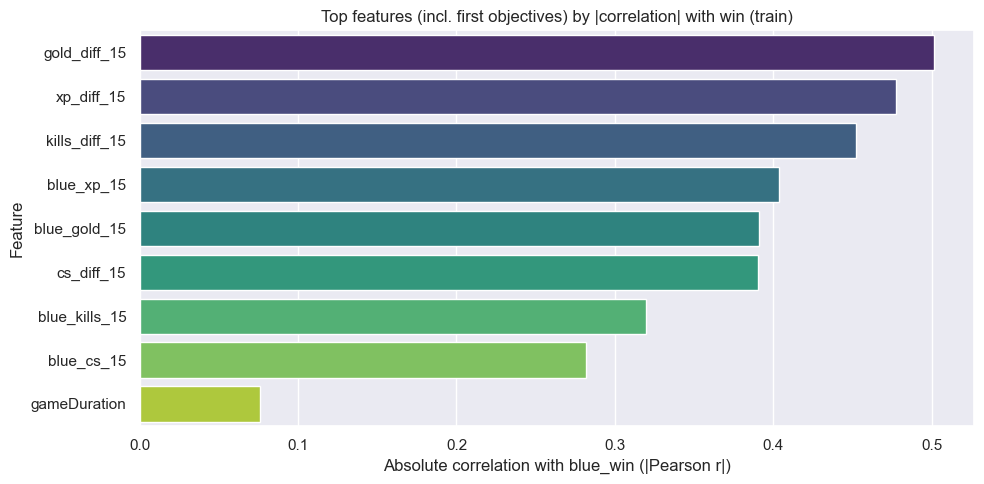

In [ ]:
# Bar chart: top absolute correlations with blue_win (train), ensuring first objectives and both sides included
if 'corr' in globals() and len(corr) > 0:
    objective_cols = [c for c in corr.index if c.startswith('first_')]
    objective_cols = sorted(objective_cols, key=lambda c: abs(corr[c]), reverse=True)
    ordered = []
    for c in objective_cols:
        if c not in ordered:
            ordered.append(c)
    for c in corr.abs().sort_values(ascending=False).index:
        if c not in ordered:
            ordered.append(c)
    chosen = ordered[:20]
    topN = corr.loc[chosen].abs().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topN.values, y=topN.index, orient='h', palette='viridis')
    plt.xlabel('Absolute correlation with blue_win (|Pearson r|)')
    plt.ylabel('Feature')
    plt.title('Top features (blue/red stats + first objectives) by |correlation| with win (train)')
    plt.tight_layout()
    plt.show()
else:
    print('Skipping bar chart: correlations not available.')

This bar chart shows the absolute strength of the 15 most correlated features with `blue_win`. Bigger bars = stronger linear association (regardless of sign).

My takeaways:
- The same early‑advantage features dominate (gold/xp/cs/kill diffs). This reinforces that the model should pay attention to tempo and resource control at 15 minutes.
- There’s a visible drop‑off after the top group, which helps me decide a sensible cut for feature selection in linear baselines.
- Because many of the top features belong to the same “early lead” cluster, including all of them in linear models may be redundant; for trees it’s less harmful but still not always necessary.

## Boxplots by outcome

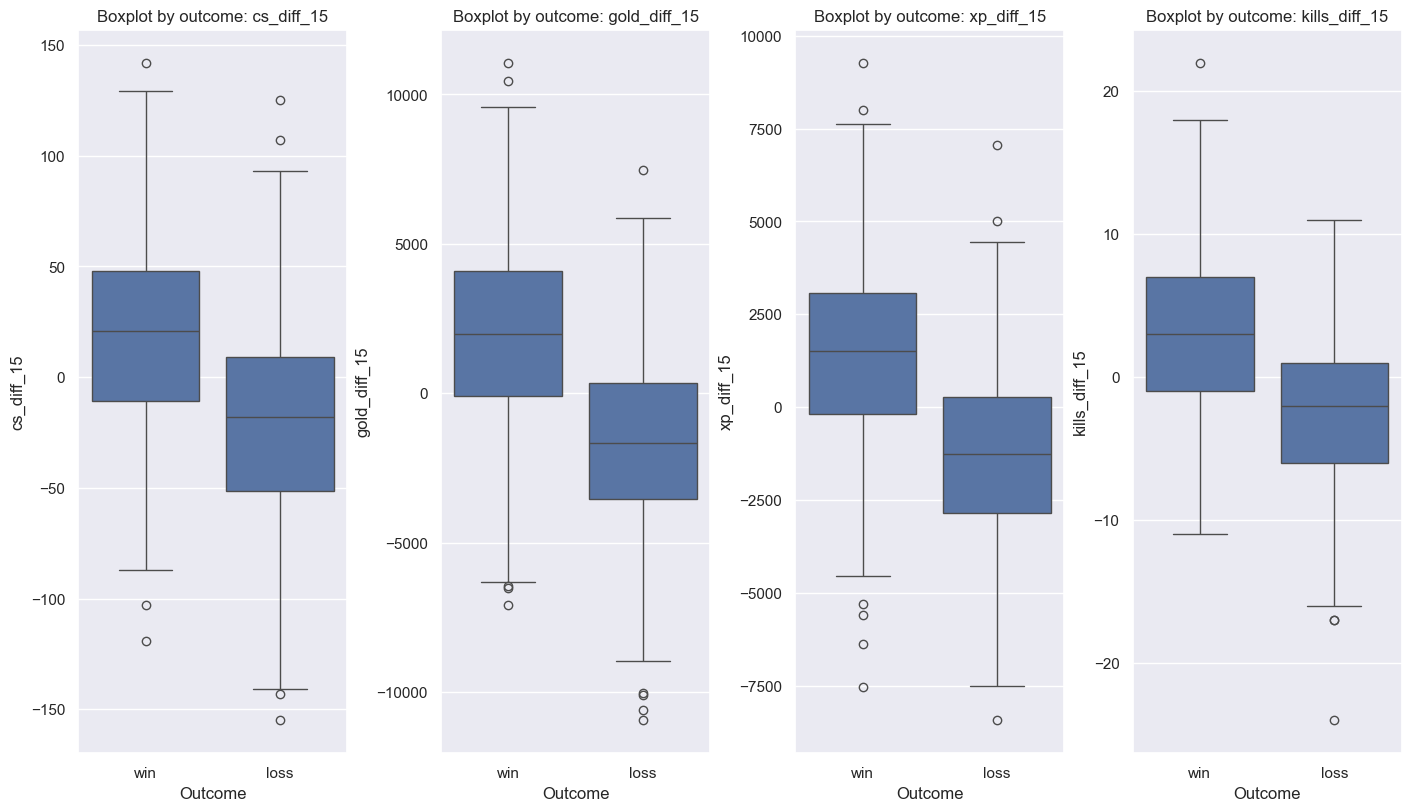

In [8]:
# Boxplots: top features by outcome (train)
if 'corr' in globals() and len(corr) > 0:
    # Ensure cs_diff_15 is shown, plus other top features
    candidates = list(corr.index)
    features = []
    if 'cs_diff_15' in train_df.columns:
        features.append('cs_diff_15')
    for f in candidates:
        if f not in features and f != 'blue_win' and (pd.api.types.is_float_dtype(train_df[f]) or train_df[f].nunique() > 10):
            features.append(f)
        if len(features) >= 4:
            break
    if features:
        bx = train_df[['blue_win'] + features].copy().replace([np.inf, -np.inf], np.nan).dropna()
        bx['blue_win'] = bx['blue_win'].map({0: 'loss', 1: 'win'})
        n = len(features)
        fig, axes = plt.subplots(1, n, figsize=(3*n+2, 8), constrained_layout=True)
        if n == 1:
            axes = [axes]
        for ax, f in zip(axes, features):
            sns.boxplot(data=bx, x='blue_win', y=f, ax=ax)
            ax.set_title(f'Boxplot by outcome: {f}')
            ax.set_xlabel('Outcome')
            ax.set_ylabel(f)
        plt.show()
    else:
        print('No features available for boxplots.')
else:
    print('Skipping boxplots: correlations not available.')

These boxplots compare the distribution of top features for wins vs losses. I look for median shifts (line inside the box), spread (box size), and outliers.

My takeaways:
- Winning games tend to have higher medians for early‑advantage features (e.g., `gold_diff_15`, `xp_diff_15`). The boxes are also narrower, hinting at more consistent leads when teams win.
- Losses have lower (or negative) medians and often wider spreads, meaning that being behind comes in many forms.
- Outliers remind me there are exceptions: some teams win from behind or lose despite a lead. That’s one reason I evaluate with multiple metrics, not just accuracy.

## Win rate by early objectives

Win rate by first_tower (train):



,win_rate,n
first_tower,,
blue,0.704961,383
red,0.311111,315


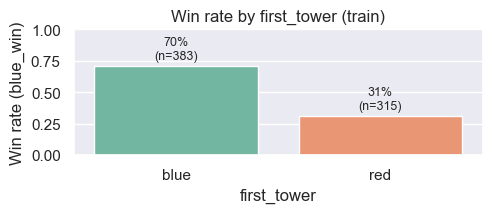

Win rate by first_dragon (train):



,win_rate,n
first_dragon,,
blue,0.627273,330
red,0.435967,367


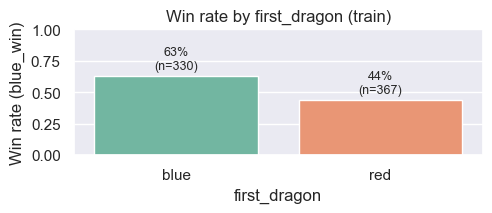

Win rate by first_herald (train):



,win_rate,n
first_herald,,
blue,0.652406,374
red,0.354839,279


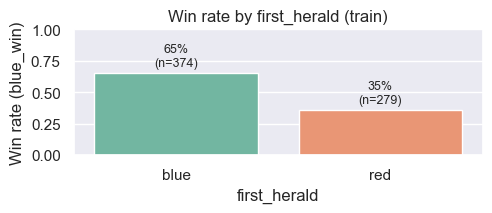

Win rate by first_grub (train):



,win_rate,n
first_grub,,
blue,0.552561,371
red,0.500000,324


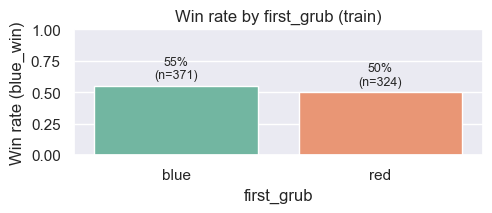

In [9]:
# Win-rate by early objective control (train only)
possible_cols = ['first_tower', 'first_turret', 'first_dragon', 'first_herald', 'first_blood', 'first_grub']
objective_cols = [col for col in possible_cols if col in train_df.columns]

for col in objective_cols:
    print(f"Win rate by {col} (train):\n")
    grp = (
        train_df.groupby(col)
        .agg(win_rate=('blue_win', 'mean'), n=('blue_win', 'size'))
        .reset_index()
    )
    display(grp.set_index(col))

    plt.figure(figsize=(5, 2.3))
    ax = sns.barplot(data=grp, x=col, y='win_rate', hue=col, palette='Set2', legend=False)
    ax.set_ylim(0, 1)
    ax.set_title(f"Win rate by {col} (train)")
    ax.set_ylabel("Win rate (blue_win)")

    for p, (_, row) in zip(ax.patches, grp.iterrows()):
        ax.annotate(
            f"{row['win_rate']:.0%}\n(n={int(row['n'])})",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()

This view summarizes how often the blue side wins when it secures early objectives first (tower, dragon, herald, etc.). Bars show win rates; the table below lists the exact percentages.

What I conclude:
- Taking the first tower and first dragon both associate with a noticeably higher win rate. These aren’t perfect predictors, but they meaningfully tilt the game.
- The uplift sizes differ: if one objective’s bar is much higher, I give it more weight in feature engineering or model interpretation.
- Caution: teams that are already ahead are more likely to take first objectives (confounding). The model can still learn useful patterns, but I don’t treat these as causal.

Practical use: I keep these as binary features (with care to avoid leakage) and let the model combine them with resource diffs.

## Evaluation (modeling)

Now I train and evaluate models, focusing on predicted win probability (0–100%). The primary model is a Random Forest classifier; we also test linearity with Logistic Regression, explore instance-based KNN, and include a simple Linear Regression as a probability regressor. XGBoost can be swapped in later if we need extra lift.

What I test:

- Models: Random Forest (main), Logistic Regression, KNN, Linear Regression (prob regressor)

- Metrics at a 0.5 threshold: Accuracy, Precision, Recall, F1

- Probability quality: ROC-AUC, PR-AUC (Average Precision), Brier score, Log Loss

- Calibration: reliability curves to check if “70% predicted” ≈ 70% observed wins

- Deliverable: a calibrated probability for blue win on the test set


What I can tell from this:

- Random Forest is my default choice for non-linear interactions among early-game features; if it’s well-calibrated and tops ROC/PR-AUC with a low Brier/Log Loss, we keep it.

In [17]:
# Helper to evaluate models as probability estimators
def evaluate_prob_model(model, X_tr, y_tr, X_te, y_te, kind: str, threshold: float = 0.5) -> Dict[str, Any]:
    fitted = model.fit(X_tr, y_tr)
    # Get probabilities
    if kind == 'classifier':
        if hasattr(fitted, 'predict_proba'):
            proba = fitted.predict_proba(X_te)[:, 1]
        elif hasattr(fitted, 'decision_function'):
            decision = fitted.decision_function(X_te)
            proba = 1 / (1 + np.exp(-decision))
        else:
            # fall back to predict and clip
            proba = fitted.predict(X_te)
    else:
        proba = fitted.predict(X_te)
    proba = np.clip(proba, 0.0, 1.0)
    # Threshold for comparability
    y_pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    # Probability-centric metrics
    roc = roc_auc_score(y_te, proba) if len(np.unique(y_te)) == 2 else np.nan
    ap = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)
    ll = log_loss(y_te, np.c_[1-proba, proba])
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc, 'avg_precision': ap, 'brier': brier, 'log_loss': ll,
        'threshold': threshold, 'fitted': fitted, 'proba': proba,
    }

In [18]:
# Define probability-focused models
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

rf_clf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    random_state=RANDOM_STATE, n_jobs=-1
)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=15, weights='distance'))
])

lin_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])  # still usable as a probability regressor

models = [
    ('Logistic Regression', logreg, 'classifier'),
    ('Random Forest (Classifier)', rf_clf, 'classifier'),
    ('K-Nearest Neighbors', knn, 'classifier'),
    ('Linear Regression (prob regressor)', lin_reg, 'regressor'),
]

In [19]:
# Train, evaluate, and collect probability metrics
prob_results = []
fitted_models: Dict[str, Any] = {}
all_probas: Dict[str, np.ndarray] = {}

for name, model, kind in models:
    try:
        m = evaluate_prob_model(model, X_train, y_train, X_test, y_test, kind)
        fitted_models[name] = m.pop('fitted')
        all_probas[name] = m.pop('proba')
        prob_results.append({'model': name, **m})
        print(f"{name}: f1={m['f1']:.3f} | roc_auc={m['roc_auc']:.3f} | ap={m['avg_precision']:.3f} | brier={m['brier']:.3f}")
    except Exception as exc:
        warnings.warn(f'{name} failed: {exc}')

prob_results_df = pd.DataFrame(prob_results).sort_values(by='roc_auc', ascending=False)
prob_results_df

Logistic Regression: f1=0.715 | roc_auc=0.803 | ap=0.835 | brier=0.182
Random Forest (Classifier): f1=0.730 | roc_auc=0.828 | ap=0.852 | brier=0.172
K-Nearest Neighbors: f1=0.698 | roc_auc=0.787 | ap=0.817 | brier=0.185
Linear Regression (prob regressor): f1=0.711 | roc_auc=0.805 | ap=0.834 | brier=0.184
Random Forest (Classifier): f1=0.730 | roc_auc=0.828 | ap=0.852 | brier=0.172
K-Nearest Neighbors: f1=0.698 | roc_auc=0.787 | ap=0.817 | brier=0.185
Linear Regression (prob regressor): f1=0.711 | roc_auc=0.805 | ap=0.834 | brier=0.184


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss,threshold
1,Random Forest (Classifier),0.733333,0.782609,0.683544,0.729730,0.827599,0.851543,0.172435,0.515269,0.5
3,Linear Regression (prob regressor),0.706667,0.739726,0.683544,0.710526,0.805313,0.834337,0.184204,0.544390,0.5
0,Logistic Regression,0.713333,0.750000,0.683544,0.715232,0.802639,0.835014,0.181862,0.541594,0.5
2,K-Nearest Neighbors,0.700000,0.742857,0.658228,0.697987,0.787128,0.816771,0.185282,0.539512,0.5


<Figure size 700x600 with 0 Axes>

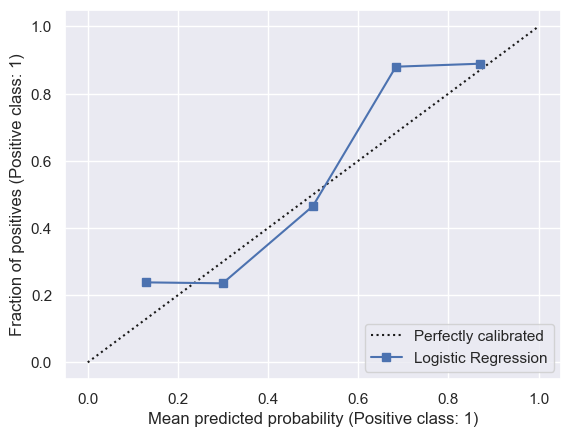

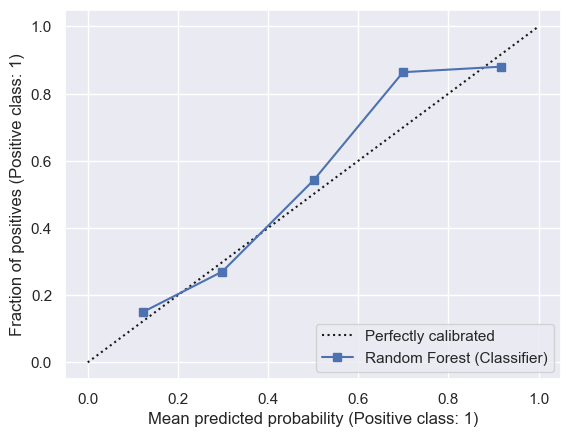

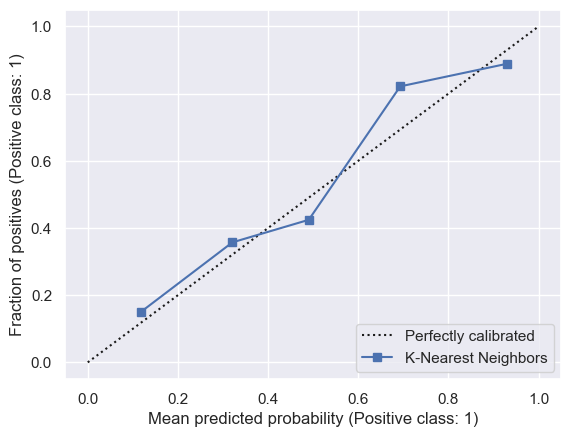

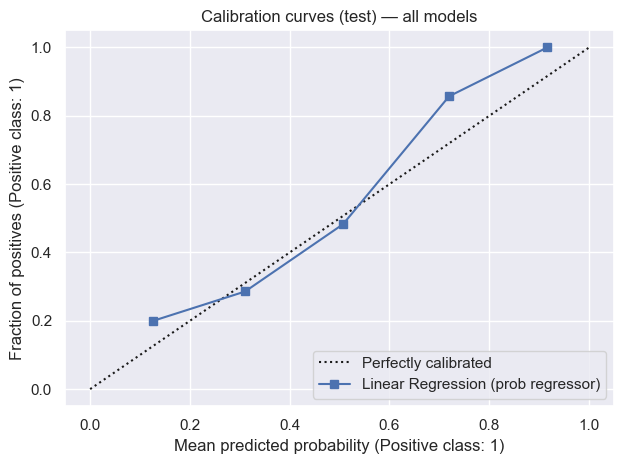

In [13]:
# Calibration (reliability) curves for all models
if 'all_probas' in globals() and len(all_probas) > 0:
    plt.figure(figsize=(7,6))
    for name, proba in all_probas.items():
        CalibrationDisplay.from_predictions(y_test, proba, name=name)
    plt.title('Calibration curves (test) — all models')
    plt.tight_layout()
    plt.show()
else:
    print('Skip calibration: no results yet.')

In [14]:
# Show a small table of predicted win probabilities (%) on test set
preview = pd.DataFrame({'blue_win': y_test.values}).copy()
for name, proba in all_probas.items():
    preview[name + ' %'] = (proba * 100).round(1)
display(preview.head(10))

,blue_win,Logistic Regression %,Random Forest (Classifier) %,K-Nearest Neighbors %,Linear Regression (prob regressor) %
0,0,36.1,34.3,40.0,39.4
1,1,64.9,58.1,68.4,61.3
2,1,32.6,48.8,54.1,37.6
3,1,49.7,45.8,38.1,49.4
4,1,80.6,51.4,44.6,76.2
5,1,45.6,49.4,28.7,46.8
6,1,99.2,94.5,100.0,100.0
7,1,59.9,48.8,33.3,57.1
8,0,24.0,50.3,53.1,30.1
9,1,82.3,75.5,80.4,78.6


## Results and interpretation (as probabilities)
I report probability-focused metrics and show predicted win chances as percentages.
- ROC-AUC and Average Precision (PR-AUC) measure ranking quality of probabilities.
- Brier score and Log Loss penalize miscalibrated/confident errors; lower is better.
- I still report F1 at a 0.5 threshold for a simple operating point, but the main deliverable is a calibrated probability between 0% and 100%.

If calibration curves are close to the diagonal, the model’s predicted percentages match empirical frequencies; otherwise, I’d consider calibration (e.g., isotonic/Platt).